In [ ]:
#1.Installing Libararies and Env Setup
!pip install wfdb neurokit2 optuna shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import neurokit2 as nk
import os
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/HealthCube-Dataset'
os.makedirs(project_path, exist_ok=True)
print(f"Project directory created at: {project_path}")

Project directory created at: /content/drive/MyDrive/HealthCube-Dataset


In [ ]:
# Load the main database file
database_path = '/content/drive/MyDrive/HealthCube-Dataset/ptbxl_database.csv'
df = pd.read_csv(database_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (21799, 28)
Columns: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr']

First few rows:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_n

In [ ]:
# 5. UNDERSTAND THE DIAGNOSTIC LABELS

# Load diagnostic statements
scp_statements = pd.read_csv('/content/drive/MyDrive/HealthCube-Dataset/scp_statements.csv', index_col=0)
print("\nDiagnostic statements (SCP codes):")
print(scp_statements.head(10))

# Function to parse diagnostic labels
def parse_scp_codes(scp_codes_str):
    try:
        return ast.literal_eval(scp_codes_str)
    except:
        return {}

df['scp_codes_parsed'] = df['scp_codes'].apply(parse_scp_codes)

agg_df = pd.read_csv('/content/drive/MyDrive/HealthCube-Dataset/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]  # Only diagnostic statements

print("\nSuperclass distribution:")
print(agg_df['diagnostic_class'].value_counts())

In [ ]:
# 6. CREATE BINARY LABELS (NORMAL vs ABNORMAL)

def create_binary_labels(row):
    """Create binary labels: 0 = Normal, 1 = Abnormal"""
    scp_codes = row['scp_codes_parsed']

    if not scp_codes:
        return np.nan

    # Check if any diagnostic code corresponds to NORM
    for code, confidence in scp_codes.items():
        if code in agg_df.index:
            diagnostic_class = agg_df.loc[code, 'diagnostic_class']
            if diagnostic_class == 'NORM' and confidence >= 50:  # High confidence normal
                return 0

    for code, confidence in scp_codes.items():
        if code in agg_df.index:
            diagnostic_class = agg_df.loc[code, 'diagnostic_class']
            if diagnostic_class in ['MI', 'STTC', 'CD', 'HYP'] and confidence >= 50:
                return 1

    return np.nan

# Apply binary labeling
df['binary_label'] = df.apply(create_binary_labels, axis=1)

# Remove rows with unclear labels
df_clean = df.dropna(subset=['binary_label']).copy()
df_clean['binary_label'] = df_clean['binary_label'].astype(int)

print(f"\nDataset after binary labeling:")
print(f"Total samples: {len(df_clean)}")
print(f"Class distribution:")
print(df_clean['binary_label'].value_counts())
print(f"Normal (0): {(df_clean['binary_label'] == 0).sum()}")
print(f"Abnormal (1): {(df_clean['binary_label'] == 1).sum()}")


Dataset after binary labeling:
Total samples: 20373
Class distribution:
binary_label
1    10935
0     9438
Name: count, dtype: int64
Normal (0): 9438
Abnormal (1): 10935



Sample ECG loaded:
Filename: records100/00000/00001_lr
Label: Normal
Signal shape: (1000, 12)
Lead names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


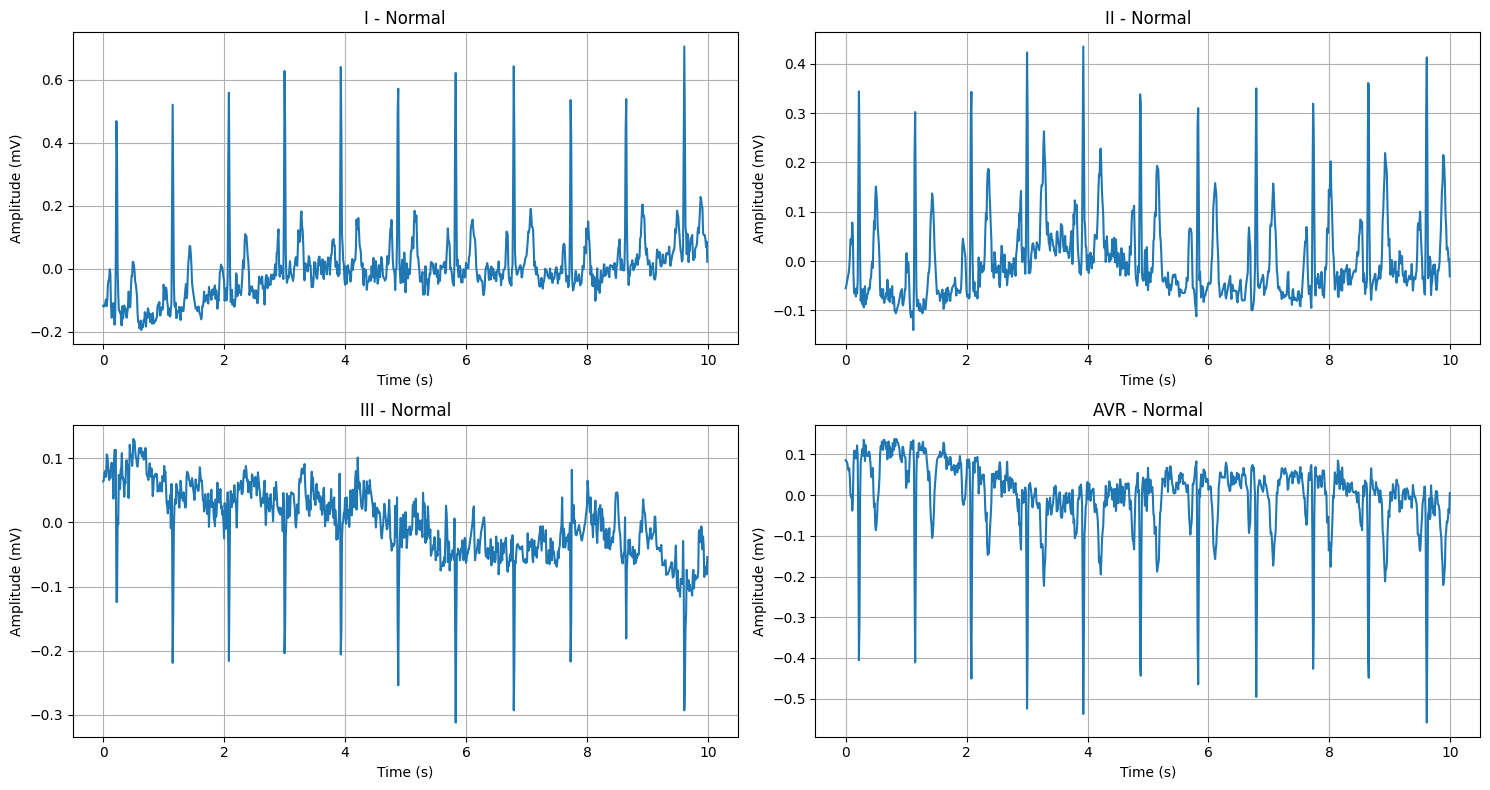

In [ ]:
# 7. SAMPLE ECG LOADING AND VISUALIZATION

def load_ecg_signal(filename, sampling_rate=100):
    try:
        if sampling_rate == 100:
            signal_path = f"/content/drive/MyDrive/HealthCube-Dataset/{filename}"

        # Load the record
        record = wfdb.rdrecord(signal_path)

        # Get the signal data and ensure it's numeric
        signal_data = record.p_signal

        # Check if signal_data is valid
        if signal_data is None:
            print(f"No signal data found in {filename}")
            return None, None

        # Convert to numpy array and ensure float type
        signal_array = np.array(signal_data, dtype=np.float64)

        # Check for valid signal
        if signal_array.size == 0:
            print(f"Empty signal in {filename}")
            return None, None

        # Handle any NaN or inf values
        if np.any(np.isnan(signal_array)) or np.any(np.isinf(signal_array)):
            print(f"Warning: {filename} contains NaN or inf values")
            # Replace NaN and inf with signal mean
            valid_mask = ~(np.isnan(signal_array) | np.isinf(signal_array))
            if np.any(valid_mask):
                signal_mean = np.mean(signal_array[valid_mask])
                signal_array[~valid_mask] = signal_mean
            else:
                print(f"All values are NaN/inf in {filename}")
                return None, None

        return signal_array, record.sig_name

    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, None

# Load a sample ECG
sample_idx = 0
sample_filename = df_clean.iloc[sample_idx]['filename_lr']
sample_label = df_clean.iloc[sample_idx]['binary_label']

signal, lead_names = load_ecg_signal(sample_filename)

if signal is not None:
    print(f"\nSample ECG loaded:")
    print(f"Filename: {sample_filename}")
    print(f"Label: {'Normal' if sample_label == 0 else 'Abnormal'}")
    print(f"Signal shape: {signal.shape}")
    print(f"Lead names: {lead_names}")

    # Plot the first few leads
    plt.figure(figsize=(15, 8))
    time_axis = np.arange(signal.shape[0]) / 100  # 100 Hz sampling rate

    for i in range(min(4, signal.shape[1])):  # Plot first 4 leads
        plt.subplot(2, 2, i+1)
        plt.plot(time_axis, signal[:, i])
        plt.title(f'{lead_names[i]} - {"Normal" if sample_label == 0 else "Abnormal"}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from scipy import stats
from scipy.signal import welch

In [ ]:
# 8. BASIC FEATURE EXTRACTION EXAMPLE

def extract_basic_features(signal, sampling_rate=100):
    """Extract basic ECG features using NeuroKit2"""
    features = {}

    try:
        # Debug: Check signal properties
        print(f"Signal shape: {signal.shape}, dtype: {signal.dtype}")

        # Ensure signal is numeric and 2D
        if not isinstance(signal, np.ndarray):
            signal = np.array(signal, dtype=np.float64)

        # Convert to float if needed
        if signal.dtype.kind in ['U', 'S']:  # String types
            print("Warning: Signal contains strings, attempting conversion...")
            signal = signal.astype(np.float64)

        # Use lead II (index 1) for heart rate analysis, fallback to lead I
        if signal.shape[1] > 1:
            lead_ii = signal[:, 1].astype(np.float64)  # Ensure numeric
        else:
            lead_ii = signal[:, 0].astype(np.float64)

        # Remove any remaining NaN or inf values
        lead_ii = lead_ii[~np.isnan(lead_ii)]
        lead_ii = lead_ii[~np.isinf(lead_ii)]

        if len(lead_ii) == 0:
            raise ValueError("No valid signal data after cleaning")

        print(f"Processing lead II: shape={lead_ii.shape}, range=[{lead_ii.min():.3f}, {lead_ii.max():.3f}]")

        # Clean the signal
        cleaned_signal = nk.ecg_clean(lead_ii, sampling_rate=sampling_rate)

        # Find R peaks
        signals, info = nk.ecg_peaks(cleaned_signal, sampling_rate=sampling_rate)

        # Extract R peak locations
        rpeaks = info['ECG_R_Peaks']

        if len(rpeaks) > 1:
            # Calculate heart rate variability
            try:
                hrv = nk.hrv_time(rpeaks, sampling_rate=sampling_rate)

                # Extract HRV features
                if not hrv.empty:
                    features['heart_rate'] = 60 / (np.mean(np.diff(rpeaks)) / sampling_rate)
                    features['sdnn'] = float(hrv['HRV_SDNN'].iloc[0]) if 'HRV_SDNN' in hrv.columns else np.nan
                    features['rmssd'] = float(hrv['HRV_RMSSD'].iloc[0]) if 'HRV_RMSSD' in hrv.columns else np.nan
                    features['pnn50'] = float(hrv['HRV_pNN50'].iloc[0]) if 'HRV_pNN50' in hrv.columns else np.nan
                else:
                    features.update({'heart_rate': np.nan, 'sdnn': np.nan, 'rmssd': np.nan, 'pnn50': np.nan})

            except Exception as hrv_error:
                print(f"HRV calculation error: {hrv_error}")
                features.update({'heart_rate': np.nan, 'sdnn': np.nan, 'rmssd': np.nan, 'pnn50': np.nan})
        else:
            print("Insufficient R peaks detected")
            features.update({'heart_rate': np.nan, 'sdnn': np.nan, 'rmssd': np.nan, 'pnn50': np.nan})

        features['signal_mean'] = float(np.mean(cleaned_signal))
        features['signal_std'] = float(np.std(cleaned_signal))
        features['signal_min'] = float(np.min(cleaned_signal))
        features['signal_max'] = float(np.max(cleaned_signal))
        features['signal_range'] = features['signal_max'] - features['signal_min']

        from scipy import stats
        features['signal_skewness'] = float(stats.skew(cleaned_signal))
        features['signal_kurtosis'] = float(stats.kurtosis(cleaned_signal))

        try:
            from scipy.signal import welch
            freqs, psd = welch(cleaned_signal, fs=sampling_rate, nperseg=min(256, len(cleaned_signal)//4))
            features['total_power'] = float(np.sum(psd))
            features['dominant_freq'] = float(freqs[np.argmax(psd)])

            low_freq_mask = (freqs >= 0.04) & (freqs <= 0.15)
            high_freq_mask = (freqs >= 0.15) & (freqs <= 0.4)
            features['lf_power'] = float(np.sum(psd[low_freq_mask]))
            features['hf_power'] = float(np.sum(psd[high_freq_mask]))
            features['lf_hf_ratio'] = features['lf_power'] / features['hf_power'] if features['hf_power'] > 0 else np.nan

        except Exception as psd_error:
            print(f"PSD calculation error: {psd_error}")
            features.update({
                'total_power': np.nan, 'dominant_freq': np.nan,
                'lf_power': np.nan, 'hf_power': np.nan, 'lf_hf_ratio': np.nan
            })

    except Exception as e:
        print(f"Feature extraction error: {e}")
        print(f"Signal info: shape={signal.shape if hasattr(signal, 'shape') else 'unknown'}, dtype={signal.dtype if hasattr(signal, 'dtype') else 'unknown'}")

        # Return NaN features in case of error
        feature_names = ['heart_rate', 'sdnn', 'rmssd', 'pnn50', 'signal_mean',
                        'signal_std', 'signal_min', 'signal_max', 'signal_range',
                        'signal_skewness', 'signal_kurtosis', 'total_power',
                        'dominant_freq', 'lf_power', 'hf_power', 'lf_hf_ratio']
        features = {name: np.nan for name in feature_names}

    return features

# Test feature extraction on sample
if signal is not None:
    sample_features = extract_basic_features(signal)
    print(f"\nExtracted features for sample ECG:")
    for feature, value in sample_features.items():
        print(f"{feature}: {value:.4f}")

Signal shape: (1000, 12), dtype: float64
Processing lead II: shape=(1000,), range=[-0.140, 0.435]

Extracted features for sample ECG:
heart_rate: 63.8298
sdnn: 20.0000
rmssd: 26.4575
pnn50: 11.1111
signal_mean: 0.0024
signal_std: 0.0729
signal_min: -0.0847
signal_max: 0.3214
signal_range: 0.4062
signal_skewness: 1.8687
signal_kurtosis: 3.3081
total_power: 0.0125
dominant_freq: 3.2000
lf_power: 0.0000
hf_power: 0.0001
lf_hf_ratio: 0.0000


In [ ]:
# 9. BATCH FEATURE EXTRACTION TEST - 50 RECORDS

def extract_features_batch(df_subset, max_samples=100):
    """Extract features from a batch of ECG recordings"""
    features_list = []
    labels_list = []
    valid_filenames = []

    print(f"Processing {min(len(df_subset), max_samples)} ECG recordings...")

    for idx, (_, row) in enumerate(df_subset.head(max_samples).iterrows()):
        filename = row['filename_lr']
        label = row['binary_label']

        print(f"Processing {idx+1}/{max_samples}: {filename}", end=" ")

        # Load signal
        signal, _ = load_ecg_signal(filename)

        if signal is not None:
            # Extract features
            features = extract_basic_features(signal)

            # Check if features are valid (not all NaN)
            valid_features = [v for v in features.values() if not np.isnan(v)]
            if len(valid_features) > 0:
                features_list.append(features)
                labels_list.append(label)
                valid_filenames.append(filename)
                print("✓ Success")
            else:
                print("✗ All features NaN")
        else:
            print("✗ Failed to load")

        # Progress indicator every 10 files
        if (idx + 1) % 10 == 0:
            print(f"\n--- Completed {idx + 1} files ---")

    print(f"\nSuccessfully processed {len(features_list)} out of {max_samples} recordings")

    # Convert to DataFrame
    if features_list:
        features_df = pd.DataFrame(features_list)
        features_df['filename'] = valid_filenames
        features_df['label'] = labels_list

        print(f"Features DataFrame shape: {features_df.shape}")
        print(f"Features extracted: {[col for col in features_df.columns if col not in ['filename', 'label']]}")

        return features_df
    else:
        print("No valid features extracted!")
        return pd.DataFrame()

# RUN THE BATCH PROCESSING
print("Starting batch feature extraction...")
print("="*50)

# Start with a small sample to test
TEST_SIZE = 50  # Start small for testing
features_df = extract_features_batch(df_clean, max_samples=TEST_SIZE)

if not features_df.empty:
    print("\n" + "="*50)
    print("BATCH PROCESSING COMPLETED SUCCESSFULLY!")
    print("="*50)

    # Display results
    print(f"Extracted features from {len(features_df)} ECG recordings")
    print(f"Features shape: {features_df.shape}")

    # Show feature statistics
    print("\nFeature Summary:")
    feature_cols = [col for col in features_df.columns if col not in ['filename', 'label']]
    print(features_df[feature_cols].describe())

    # Check for missing values
    print(f"\nMissing values per feature:")
    missing_counts = features_df[feature_cols].isnull().sum()
    print(missing_counts[missing_counts > 0])

    # Class distribution
    print(f"\nClass distribution in extracted features:")
    print(features_df['label'].value_counts())

    # Save the features
    output_file = 'ecg_features_sample.csv'
    features_df.to_csv(output_file, index=False)
    print(f"\nFeatures saved to: {output_file}")

else:
    print("\n❌ BATCH PROCESSING FAILED!")
    print("Check the error messages above and verify:")
    print("1. Dataset downloaded correctly")
    print("2. File paths are correct")
    print("3. ECG files can be loaded")


Dataset Overview:
Total recordings: 20373
Age range: 2 - 300 years
Gender distribution:
sex
0    10525
1     9848
Name: count, dtype: int64

Class balance:
binary_label
1    0.53674
0    0.46326
Name: proportion, dtype: float64


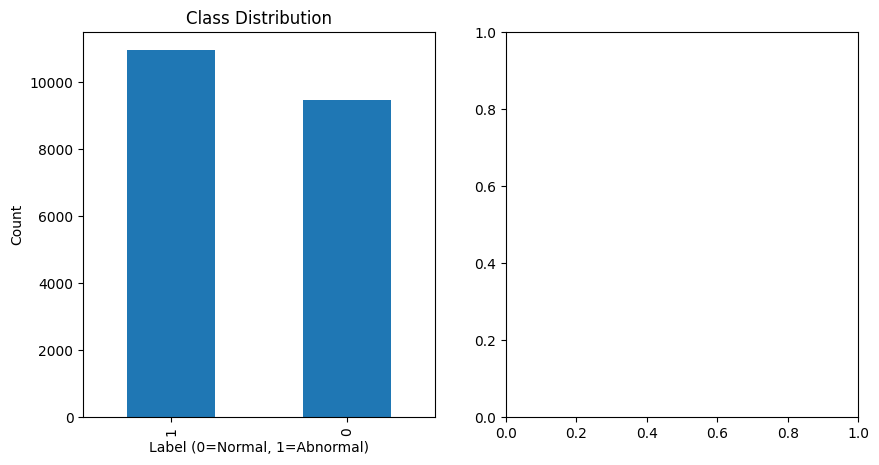

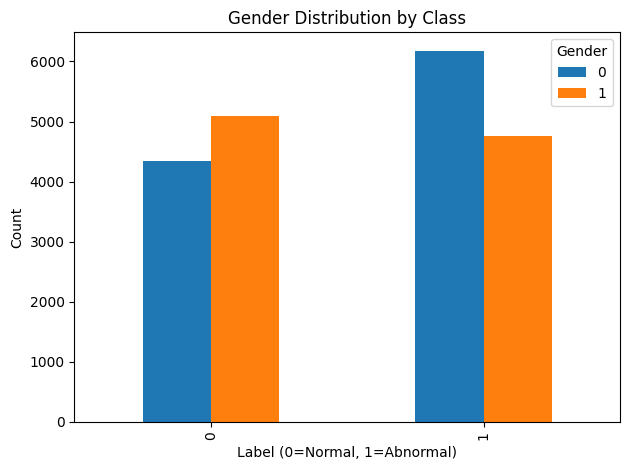

In [ ]:
# 10. INITIAL DATA EXPLORATION

print(f"\nDataset Overview:")
print(f"Total recordings: {len(df_clean)}")
print(f"Age range: {df_clean['age'].min():.0f} - {df_clean['age'].max():.0f} years")
print(f"Gender distribution:")
print(df_clean['sex'].value_counts())
print(f"\nClass balance:")
print(df_clean['binary_label'].value_counts(normalize=True))

# Plot class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_clean['binary_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label (0=Normal, 1=Abnormal)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df_clean.groupby(['binary_label', 'sex']).size().unstack().plot(kind='bar')
plt.title('Gender Distribution by Class')
plt.xlabel('Label (0=Normal, 1=Abnormal)')
plt.ylabel('Count')
plt.legend(title='Gender')

plt.tight_layout()
plt.show()

In [ ]:
# LARGE-SCALE FEATURE EXTRACTION - 2000 RECORDS

print("🚀 Starting large-scale feature extraction...")
print("="*60)

# Configuration
LARGE_BATCH_SIZE = 2000
OUTPUT_FILENAME = 'ecg_features_dataset_2000.csv'
CHECKPOINT_INTERVAL = 100  # Save progress every 100 files

total_available = len(df_clean)
actual_batch_size = min(LARGE_BATCH_SIZE, total_available)

print(f"📊 Dataset Info:")
print(f"   Total available records: {total_available}")
print(f"   Requested batch size: {LARGE_BATCH_SIZE}")
print(f"   Actual processing size: {actual_batch_size}")
print(f"   Output file: {OUTPUT_FILENAME}")
print()

def extract_features_large_batch(df_subset, max_samples=2000, checkpoint_interval=100):
    features_list = []
    labels_list = []
    valid_filenames = []
    failed_files = []

    total_to_process = min(len(df_subset), max_samples)

    print(f"🔄 Processing {total_to_process} ECG recordings...")
    print(f"💾 Checkpoints every {checkpoint_interval} files")
    print(f"📊 Progress updates every 10 files")
    print("-" * 60)

    # Test first file immediately
    print("🧪 Testing first file...")
    first_row = df_subset.iloc[0]
    test_filename = first_row['filename_lr']
    print(f"   Loading: {test_filename}")

    test_signal, _ = load_ecg_signal(test_filename)
    if test_signal is not None:
        print(f"   ✅ Signal loaded: shape={test_signal.shape}")
        print("   🔄 Testing feature extraction...")
        test_features = extract_comprehensive_features(test_signal)
        valid_test = [v for v in test_features.values() if not np.isnan(v)]
        print(f"   ✅ Features extracted: {len(valid_test)}/{len(test_features)} valid")
        print("   🚀 Starting batch processing...")
    else:
        print(f"   ❌ FAILED to load first file! Check dataset path.")
        return pd.DataFrame(), []

    print("-" * 60)

    for idx, (_, row) in enumerate(df_subset.head(max_samples).iterrows()):
        filename = row['filename_lr']
        label = row['binary_label']

        # Progress indicator
        progress = ((idx + 1) / total_to_process) * 100

        # Immediate feedback for first few files
        if idx < 5:
            print(f"File {idx+1}: {filename} - Loading...", end=" ")

        # Load and process signal
        signal, _ = load_ecg_signal(filename)

        if signal is not None:
            if idx < 5:
                print(f"Loaded ✅ - Extracting features...", end=" ")

            try:
                # Extract comprehensive features (50+ features)
                features = extract_comprehensive_features(signal)

                # Check if features are valid (not all NaN)
                valid_features = [v for v in features.values() if not np.isnan(v)]
                if len(valid_features) >= 10:  # At least 10 valid features
                    features_list.append(features)
                    labels_list.append(label)
                    valid_filenames.append(filename)
                    if idx < 5:
                        print(f"Success ✅ ({len(valid_features)} features)")
                else:
                    failed_files.append((filename, "insufficient_features"))
                    if idx < 5:
                        print(f"Failed ❌ (only {len(valid_features)} valid features)")

            except Exception as e:
                failed_files.append((filename, str(e)))
                if idx < 5:
                    print(f"Error ❌ ({str(e)[:50]}...)")
        else:
            failed_files.append((filename, "load_failed"))
            if idx < 5:
                print(f"Load failed ❌")

        # Regular progress updates every 10 files
        if (idx + 1) % 10 == 0:
            print(f"Progress: {idx+1:4d}/{total_to_process} ({progress:5.1f}%) | "
                  f"✅ Success: {len(features_list):4d} | "
                  f"❌ Failed: {len(failed_files):3d}")

        # Major milestone updates
        if (idx + 1) % 50 == 0:
            success_rate = len(features_list) / (idx + 1) * 100
            print(f"🎯 MILESTONE: {idx+1} files processed | Success rate: {success_rate:.1f}%")
        else:
            failed_files.append((filename, "load_failed"))

        # Checkpoint save
        if (idx + 1) % checkpoint_interval == 0 and features_list:
            checkpoint_df = pd.DataFrame(features_list)
            checkpoint_df['filename'] = valid_filenames
            checkpoint_df['label'] = labels_list

            checkpoint_file = f"checkpoint_{idx+1}_{OUTPUT_FILENAME}"
            checkpoint_df.to_csv(checkpoint_file, index=False)
            print(f"\n💾 Checkpoint saved: {checkpoint_file}")

    print(f"\n🏁 Processing complete!")
    print(f"✅ Successfully processed: {len(features_list)}")
    print(f"❌ Failed: {len(failed_files)}")

    # Create final DataFrame
    if features_list:
        final_df = pd.DataFrame(features_list)
        final_df['filename'] = valid_filenames
        final_df['label'] = labels_list

        # Add metadata columns
        final_df['patient_id'] = [df_clean[df_clean['filename_lr'] == f]['patient_id'].iloc[0]
                                 for f in valid_filenames]
        final_df['age'] = [df_clean[df_clean['filename_lr'] == f]['age'].iloc[0]
                          for f in valid_filenames]
        final_df['sex'] = [df_clean[df_clean['filename_lr'] == f]['sex'].iloc[0]
                          for f in valid_filenames]

        return final_df, failed_files
    else:
        return pd.DataFrame(), failed_files

# Run the large batch processing
print("⏱️  Estimated time: ~30-60 minutes for 2000 records")
print("☕ Grab a coffee! This will take a while...")
print()

# Start timer
import time
start_time = time.time()

# Run the processing
large_features_df, failed_list = extract_features_large_batch(
    df_clean,
    max_samples=actual_batch_size,
    checkpoint_interval=CHECKPOINT_INTERVAL
)

# End timer
end_time = time.time()
processing_time = end_time - start_time

print("\n" + "="*60)
print("🎉 LARGE-SCALE PROCESSING COMPLETED!")
print("="*60)

if not large_features_df.empty:
    # Display results
    print(f"📈 Final Results:")
    print(f"   Total records processed: {len(large_features_df)}")
    print(f"   Features extracted: {large_features_df.shape[1] - 4}")  # -4 for metadata
    print(f"   Processing time: {processing_time/60:.1f} minutes")
    print(f"   Average time per record: {processing_time/len(large_features_df):.2f} seconds")

    # Class distribution
    print(f"\n📊 Class Distribution:")
    class_counts = large_features_df['label'].value_counts()
    print(f"   Normal (0): {class_counts.get(0, 0)} ({class_counts.get(0, 0)/len(large_features_df)*100:.1f}%)")
    print(f"   Abnormal (1): {class_counts.get(1, 0)} ({class_counts.get(1, 0)/len(large_features_df)*100:.1f}%)")

    # Feature quality check
    feature_cols = [col for col in large_features_df.columns
                   if col not in ['filename', 'label', 'patient_id', 'age', 'sex']]

    print(f"\n🔍 Data Quality Check:")
    missing_percentages = (large_features_df[feature_cols].isnull().sum() / len(large_features_df) * 100)
    high_missing = missing_percentages[missing_percentages > 20]

    if len(high_missing) > 0:
        print(f"   ⚠️  Features with >20% missing values:")
        for feat, pct in high_missing.items():
            print(f"      {feat}: {pct:.1f}% missing")
    else:
        print(f"   ✅ All features have <20% missing values")

    print(f"   📊 Feature statistics:")
    print(f"      Mean missing per feature: {missing_percentages.mean():.1f}%")
    print(f"      Max missing per feature: {missing_percentages.max():.1f}%")

    # Save the final dataset
    large_features_df.to_csv(OUTPUT_FILENAME, index=False)
    print(f"\n💾 Dataset saved to: {OUTPUT_FILENAME}")
    print(f"   File size: {os.path.getsize(OUTPUT_FILENAME) / (1024*1024):.1f} MB")

    # Save metadata about failed files
    if failed_list:
        failed_df = pd.DataFrame(failed_list, columns=['filename', 'error_reason'])
        failed_filename = f"failed_files_{OUTPUT_FILENAME}"
        failed_df.to_csv(failed_filename, index=False)
        print(f"   Failed files log: {failed_filename}")

    # Quick data preview
    print(f"\n👀 Data Preview:")
    print(large_features_df.head(3))

    print(f"\n🎯 READY FOR VS CODE!")
    print(f"   Your dataset: {OUTPUT_FILENAME}")
    print(f"   Shape: {large_features_df.shape}")
    print(f"   Download to local machine and continue in VS Code")

else:
    print("❌ Large-scale processing failed!")
    print("Check the error logs and try with a smaller batch size first.")

print("="*60)

In [ ]:
# IMMEDIATE DIAGNOSTIC - Run this cell to check if setup is working
print("🔍 DIAGNOSTIC CHECK...")

# 1. Check if dataset exists
print(f"1. Dataset shape: {df_clean.shape}")
print(f"2. First filename: {df_clean.iloc[0]['filename_lr']}")

# 2. Test file loading
test_file = df_clean.iloc[0]['filename_lr']
print(f"3. Testing file load: {test_file}")

signal, leads = load_ecg_signal(test_file)
print(f"4. Signal loaded: {signal is not None}")
if signal is not None:
    print(f"   Shape: {signal.shape}")
    print(f"   Type: {type(signal)}")
else:
    print("   ❌ SIGNAL LOADING FAILED!")
    # Check file path
    print(f"   Checking path: records100/{test_file}")
    import os
    print(f"   File exists: {os.path.exists(f'records100/{test_file}')}")
    print(f"   Directory exists: {os.path.exists('records100')}")
    if os.path.exists('records100'):
        print(f"   Files in directory: {len(os.listdir('records100'))}")

print("🔍 Diagnostic complete!")

🔍 DIAGNOSTIC CHECK...
1. Dataset shape: (20373, 30)
2. First filename: records100/00000/00001_lr
3. Testing file load: records100/00000/00001_lr
4. Signal loaded: True
   Shape: (1000, 12)
   Type: <class 'numpy.ndarray'>
🔍 Diagnostic complete!


In [ ]:
# QUICK FIX - Define the enhanced feature extraction function
def extract_comprehensive_features(signal, sampling_rate=100):
    features = {}

    try:
        # Ensure signal is numeric and 2D
        if not isinstance(signal, np.ndarray):
            signal = np.array(signal, dtype=np.float64)
        if signal.dtype.kind in ['U', 'S']:
            signal = signal.astype(np.float64)

        # Handle NaN/inf values
        signal = np.nan_to_num(signal, nan=0.0, posinf=0.0, neginf=0.0)

        print(f"Processing signal: shape={signal.shape}, leads={signal.shape[1]}")

        # Use Lead II for main analysis
        lead_ii = signal[:, 1] if signal.shape[1] > 1 else signal[:, 0]
        cleaned_signal = nk.ecg_clean(lead_ii, sampling_rate=sampling_rate)

        # 1. BASIC MULTI-LEAD STATISTICS
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        for i, lead_name in enumerate(lead_names[:min(signal.shape[1], 12)]):
            lead_signal = signal[:, i]
            cleaned_lead = nk.ecg_clean(lead_signal, sampling_rate=sampling_rate)

            features[f'{lead_name}_mean'] = float(np.mean(cleaned_lead))
            features[f'{lead_name}_std'] = float(np.std(cleaned_lead))
            features[f'{lead_name}_range'] = float(np.max(cleaned_lead) - np.min(cleaned_lead))
            features[f'{lead_name}_skewness'] = float(stats.skew(cleaned_lead))

        # 2. HEART RATE VARIABILITY
        try:
            signals_info, info = nk.ecg_peaks(cleaned_signal, sampling_rate=sampling_rate)
            rpeaks = info['ECG_R_Peaks']

            if len(rpeaks) > 2:
                rr_intervals = np.diff(rpeaks) / sampling_rate * 1000  # ms

                features['heart_rate'] = 60000 / np.mean(rr_intervals)
                features['sdnn'] = float(np.std(rr_intervals))
                features['rmssd'] = float(np.sqrt(np.mean(np.diff(rr_intervals)**2)))
                features['pnn50'] = float(np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100)
                features['cvnn'] = float(np.std(rr_intervals) / np.mean(rr_intervals))

                # Frequency domain HRV
                if len(rr_intervals) > 10:
                    freqs, psd = welch(rr_intervals, fs=4, nperseg=min(64, len(rr_intervals)//4))

                    lf_band = (freqs >= 0.04) & (freqs <= 0.15)
                    hf_band = (freqs >= 0.15) & (freqs <= 0.4)

                    features['lf_power'] = float(np.sum(psd[lf_band]))
                    features['hf_power'] = float(np.sum(psd[hf_band]))
                    features['lf_hf_ratio'] = features['lf_power'] / features['hf_power'] if features['hf_power'] > 0 else 0
            else:
                # Default HRV values if insufficient peaks
                hrv_features = ['heart_rate', 'sdnn', 'rmssd', 'pnn50', 'cvnn', 'lf_power', 'hf_power', 'lf_hf_ratio']
                for feat in hrv_features:
                    features[feat] = np.nan

        except Exception as hrv_error:
            print(f"HRV error: {hrv_error}")
            hrv_features = ['heart_rate', 'sdnn', 'rmssd', 'pnn50', 'cvnn', 'lf_power', 'hf_power', 'lf_hf_ratio']
            for feat in hrv_features:
                features[feat] = np.nan

        # 3. SPECTRAL FEATURES
        try:
            freqs, psd = welch(cleaned_signal, fs=sampling_rate, nperseg=min(256, len(cleaned_signal)//4))

            features['total_power'] = float(np.sum(psd))
            features['dominant_freq'] = float(freqs[np.argmax(psd)])
            features['spectral_centroid'] = float(np.sum(freqs * psd) / np.sum(psd))
            features['spectral_bandwidth'] = float(np.sqrt(np.sum(((freqs - features['spectral_centroid'])**2) * psd) / np.sum(psd)))

        except Exception as spectral_error:
            print(f"Spectral error: {spectral_error}")
            spectral_features = ['total_power', 'dominant_freq', 'spectral_centroid', 'spectral_bandwidth']
            for feat in spectral_features:
                features[feat] = np.nan

        # 4. SIGNAL STATISTICS
        features['signal_mean'] = float(np.mean(cleaned_signal))
        features['signal_std'] = float(np.std(cleaned_signal))
        features['signal_min'] = float(np.min(cleaned_signal))
        features['signal_max'] = float(np.max(cleaned_signal))
        features['signal_skewness'] = float(stats.skew(cleaned_signal))
        features['signal_kurtosis'] = float(stats.kurtosis(cleaned_signal))

        print(f"✅ Extracted {len(features)} features successfully")

    except Exception as e:
        print(f"❌ Feature extraction failed: {e}")
        # Return basic feature set with NaN values
        features = {f'feature_{i}': np.nan for i in range(50)}

    return features

print("✅ Enhanced feature extraction function defined!")
print("📊 Expected features: ~60-70 per ECG recording")

✅ Enhanced feature extraction function defined!
📊 Expected features: ~60-70 per ECG recording
